# Degree distributions

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns

As we know, means of distributions do not always tell the entire story. For example, here is the distribution of the degrees of all the nodes in our Twitch network example.

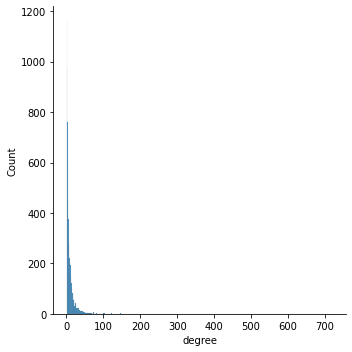

In [2]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
twitch_degrees = pd.DataFrame(twitch.degree,columns=["node","degree"])
hist = sns.displot(data=twitch_degrees,x="degree")

A few nodes in the network have hundreds of friends:

In [3]:
friend_counts = twitch_degrees["degree"].value_counts()
friend_counts.sort_values()

86        1
79        1
135       1
186       1
154       1
       ... 
5       458
4       605
3       761
2       979
1      1161
Name: degree, Length: 130, dtype: int64

These "gregarious nodes" or *hubs* create the long tail in the degree distribution.

We can find the average degree of this network and create an ER graph with the same expected average degree.

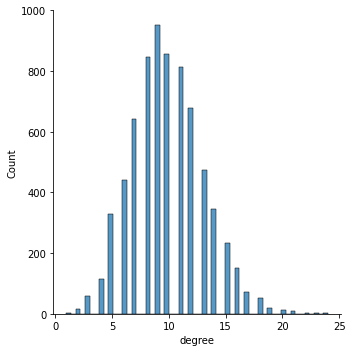

In [4]:
n = twitch.number_of_nodes()
kbar = 2*twitch.number_of_edges()/n
p = kbar/(n-1)
ER = nx.erdos_renyi_graph(n,p,seed=100)
degrees = pd.DataFrame(ER.degree,columns=["node","degree"])
hist = sns.displot(data=degrees,x="degree")

We already know that ER fails to replicate the clustering of the Twitch network. The dramatic difference in degree distributions confirms its unsuitability as a model.

A WS graph likewise lacks the proper long tail in the Twitch degree distribution:

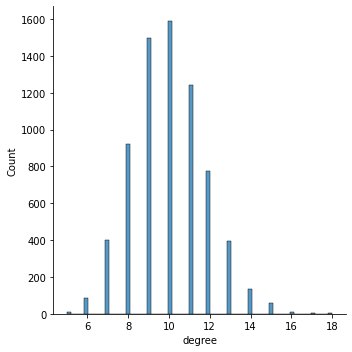

In [5]:
k,q = 10,0.4
WS = nx.watts_strogatz_graph(n,k,q,seed=1000)
degrees = pd.DataFrame(WS.degree,columns=["node","degree"])
hist = sns.displot(data=degrees,x="degree")

## Power-law distribution

The behavior of the Twitch degree distribution gets very interesting when the axes are transformed to use log scales:

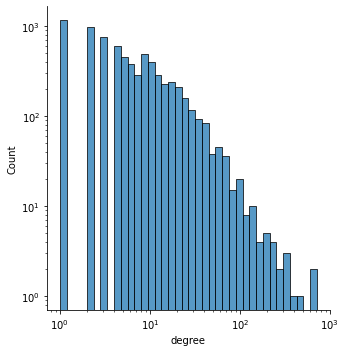

In [6]:
hist = sns.displot(data=twitch_degrees,x="degree",log_scale=True)
hist.axes[0,0].set_yscale("log")

For degrees between 10 and several hundred, the counts lie nearly on a straight line. That is, if $x$ is degree and $y$ is the node count at that degree, then

$$
\log(y) \approx  - a\cdot \log(x) + b,
$$

i.e.,

$$
y \approx B x^{-a},
$$

for some $a > 0$. This relationship is known as a **power law**. Many social networks seem to follow a power-law distrubution of node degrees, to some extent. (The precise extent is a subject of hot debate.)

Note that the decay of $x^{-a}$ as $x\to\infty$ is much slower than, say, the normal distribution's $e^{-x^2/2}$. This is a manifestation of the long tail. One effect is that there is a significant disparity between the mean and median values of the node degrees:

In [7]:
twitch_degrees["degree"].describe()

count    7126.000000
mean        9.914117
std        22.190263
min         1.000000
25%         2.000000
50%         5.000000
75%        11.000000
max       720.000000
Name: degree, dtype: float64

The summary above also shows that the standard deviation is much larger than the mean. This is another indication that the degree distribution is widely dispersed over orders of magnitude.

We can get a fair estimate of the constants $B$ and $a$ in the power law by doing a least-squares fit on the logs of $x$ and $y$. First, we need the counts:

In [8]:
y = twitch_degrees["degree"].value_counts()
counts = pd.DataFrame({"degree":y.index,"count":y.values})
counts = counts[(counts["count"] > 10) & (counts["count"] < 200)];

Now we will get additional columns by log transformations. (Note: the `np.log` function is the natural logarithm.)

In [9]:
counts[["log_x","log_y"]] = counts.transform(np.log)

Now we use `sklearn` for a linear regression.

In [10]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(counts[["log_x"]],counts["log_y"])
lm.coef_[0],lm.intercept_

(-2.135847745320904, 10.397579197774625)

The first value, which is both the slope of the line and the exponent of $x$ the power law, is the most interesting part. It estimates that the degree counts vary as $Bx^{-2.1}$ over a wide range of degrees.

## Barabási–Albert graphs

A random **Barabási–Albert** graph (BA graph) is constructed by starting with a small seed network and connecting one node at a time with $m$ new edges to it. Edges are added randomly, but preference is given to connect to nodes that already have higher degree (i.e., are more "popular"). Because of this rule, there is a natural tendency to develop a few hubs of high degree.

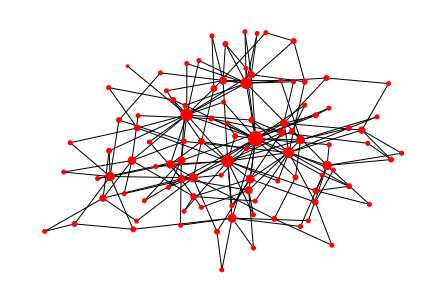

In [11]:
BA = nx.barabasi_albert_graph(100,2,seed=0)
BA_degrees = pd.DataFrame(BA.degree,columns=["node","degree"])
nx.draw(BA,node_size=8*BA_degrees["degree"],node_color="red")

Since we add $m$ edges (almost) $n$ times, the expected average degree is $2mn/n=2m$. When we scale the construction up to the size and average degree of the Twitch network, a power-law distribution emerges.

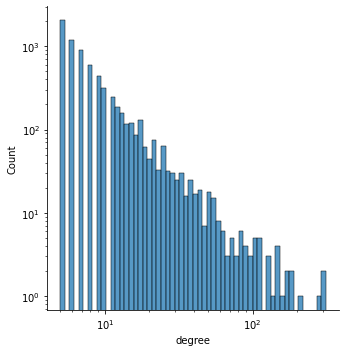

In [12]:
m = round(kbar/2)
BA = nx.barabasi_albert_graph(n,m,seed=5)
BA_degrees = pd.DataFrame(BA.degree,columns=["node","degree"])
hist = sns.displot(data=BA_degrees,x="degree",log_scale=True)
hist.axes[0,0].set_yscale("log")

Theory predicts that the exponent of the power-law distribution in a BA graph is $-3$.

In [13]:
y = BA_degrees["degree"].value_counts()
counts = pd.DataFrame({"degree":y.index,"count":y.values})
counts = counts[(counts["count"] > 10) & (counts["count"] < 100)];
counts[["log_x","log_y"]] = counts.transform(np.log)
lm = LinearRegression()
lm.fit(counts[["log_x"]],counts["log_y"])
print("exponent of power law:",lm.coef_[0])

exponent of power law: -2.912997677515427


Let's check distances and clustering, too. As a reminder, the mean distance in the Twitch network is approximately:

In [14]:
from numpy.random import default_rng
rng = default_rng(1)

def pairdist(G):
    n = nx.number_of_nodes(G)
    i = j = rng.integers(0,n)
    while i==j: j=rng.integers(0,n)   # get distinct nodes
    return nx.shortest_path_length(G,source=i,target=j)

print("Mean distance in Twitch graph:",sum(pairdist(twitch) for _ in range(4000))/4000)

Mean distance in Twitch graph: 3.657


Now we repeat that for some BA graphs.

In [15]:
dbar = []
seed = 911
for iter in range(10):
    BA = nx.barabasi_albert_graph(n,m,seed=seed)
    d = sum(pairdist(BA) for _ in range(200))/200
    dbar.append(d)
    seed += 1

print("Mean distance in BA graphs:",np.mean(dbar))

Mean distance in BA graphs: 3.5555


Not bad! Now, let's check the clustering:

In [16]:
print("Mean clustering in Twitch graph:",nx.average_clustering(twitch))

Mean clustering in Twitch graph: 0.13092821901472096


In [17]:
cbar = []
seed = 59
for iter in range(20):
    BA = nx.barabasi_albert_graph(n,m,seed=seed)
    cbar.append(nx.average_clustering(BA))
    seed += 1
    
print("Mean clustering in BA graphs:",np.mean(cbar))

Mean clustering in BA graphs: 0.009219743245252128


The BA model is our closest approach so far, but it fails to produce the small-world effect that we find in the Twitch network.